In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import random
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
from keras.utils import plot_model
import seaborn as sns

In [4]:
# Đường dẫn tới thư mục chứa dữ liệu cho tập train và tập validation
train_dir = 'data/train_new'
val_dir = 'data/val'
test_dir = 'data/test'


row = 48
col = 48
classes = len(os.listdir('data/train'))

In [5]:
def count_images(directory):
    # Đếm số lượng ảnh trong thư mục chỉ định
    image_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpeg', 'jpg', 'png', 'bmp', 'gif')):
                image_count += 1
    return image_count


In [5]:
# Đếm số lượng ảnh trong tập train và test
train_image_count = count_images(train_dir)
val_image_count = count_images(val_dir)
test_image_count = count_images(test_dir)

print(f'Số lượng ảnh trong tập train: {train_image_count}')
print(f'Số lượng ảnh trong tập train: {val_image_count}')
print(f'Số lượng ảnh trong tập test: {test_image_count}')

Số lượng ảnh trong tập train: 22965
Số lượng ảnh trong tập train: 5744
Số lượng ảnh trong tập test: 7178


In [6]:
# Function to count images in each class
def count_images_in_directory(directory):
    class_counts = {}
    # Iterate over class directories and count images
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Count the number of files in each class directory
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7764\609182860.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7764\609182860.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7764\609182860.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


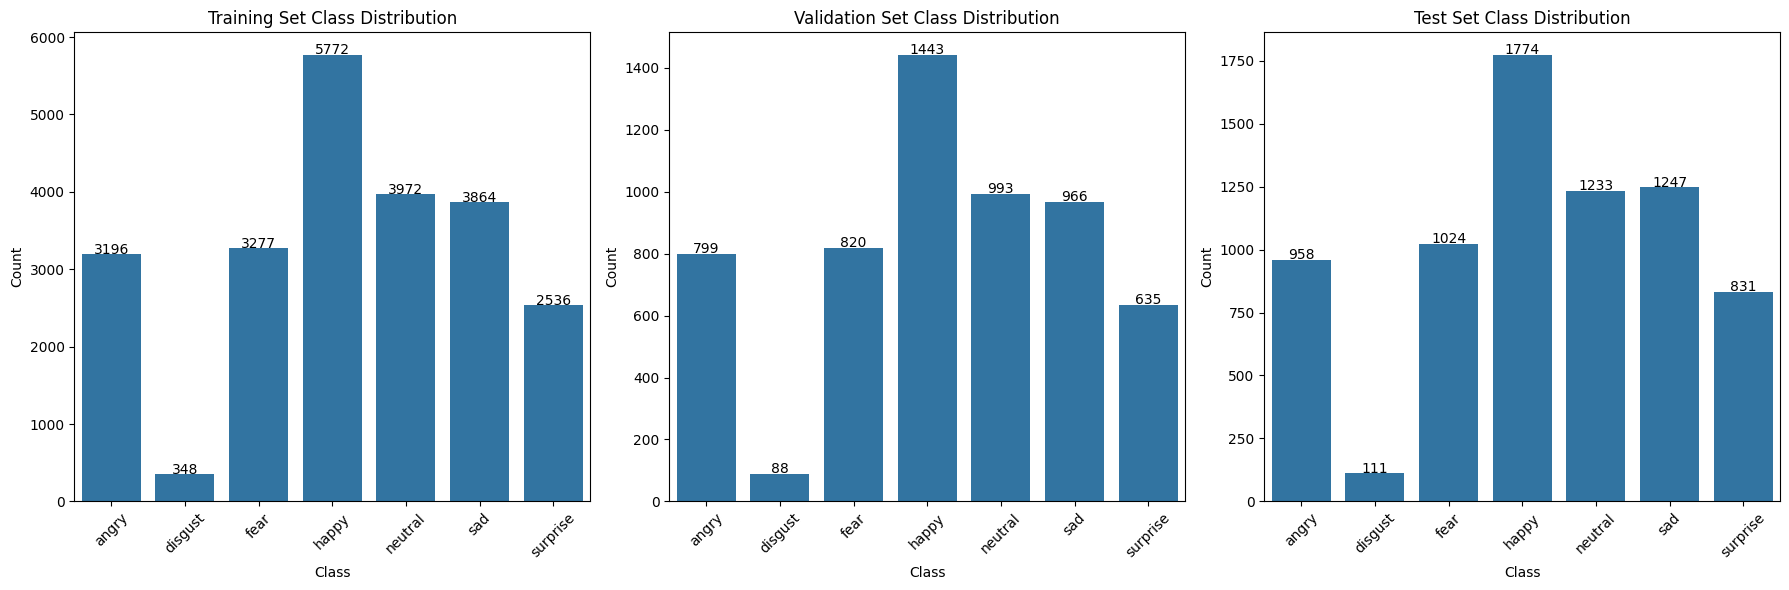

In [11]:
# Get class counts for training, validation, and test datasets
train_class_counts = count_images_in_directory(train_dir)

# Get test set class counts
val_class_counts = count_images_in_directory(val_dir)

# Get validation set class counts
test_class_counts = count_images_in_directory(test_dir)

def plot_with_counts(ax, data, title):
    sns.barplot(x=list(data.keys()), y=list(data.values()), ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, '%d' % int(height), ha='center', size=10)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot train set class distribution
plot_with_counts(axes[0], train_class_counts, 'Training Set Class Distribution')

# Plot validation set class distribution
plot_with_counts(axes[1], val_class_counts, 'Validation Set Class Distribution')

# Plot test set class distribution
plot_with_counts(axes[2], test_class_counts, 'Test Set Class Distribution')

plt.tight_layout()
plt.show()

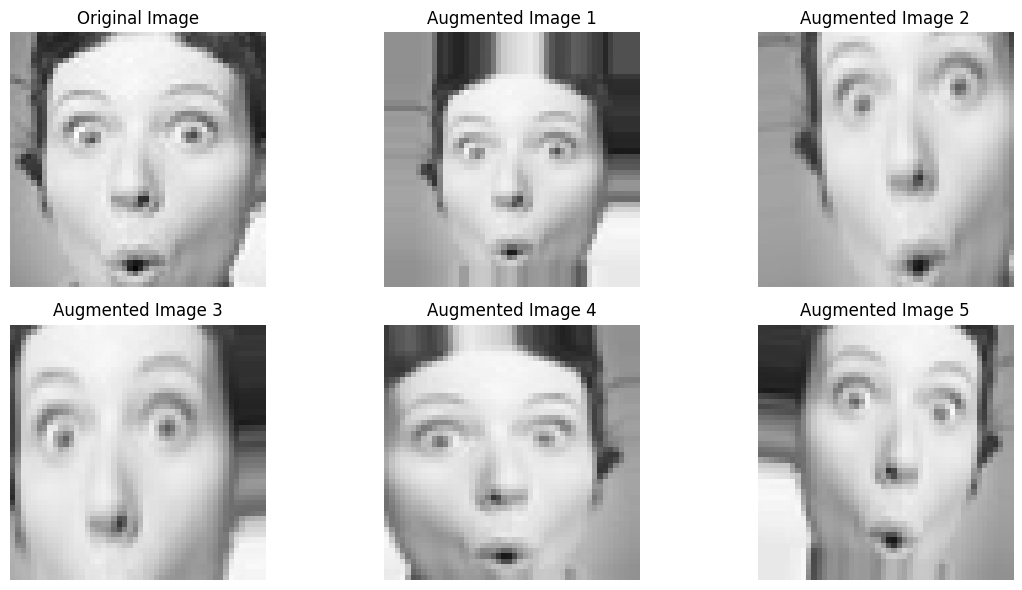

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Cấu hình ImageDataGenerator cho việc tăng cường dữ liệu
datagen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.3,
                             horizontal_flip=True,
                             rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.2)

# Đường dẫn đến ảnh cần tăng cường
img_path = "data/train_new/surprise/Training_336818.jpg"

# Đọc ảnh gốc
img = load_img(img_path)
x = img_to_array(img)
x = x.reshape((1,) + x.shape)  # Reshape thành (1, height, width, channels)

# Tạo ảnh tăng cường
augmented_images = []
for batch in datagen.flow(x, batch_size=1):
    augmented_images.append(batch[0])
    if len(augmented_images) >= 5:
        break  # Dừng sau khi đã tạo đủ số lượng ảnh tăng cường

# Hiển thị ảnh gốc và 5 ảnh tăng cường
plt.figure(figsize=(12, 6))

# Ảnh gốc
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# 5 ảnh tăng cường
for i, augmented_image in enumerate(augmented_images):
    plt.subplot(2, 3, i + 2)
    plt.imshow(augmented_image)
    plt.title(f'Augmented Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7764\609182860.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7764\609182860.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


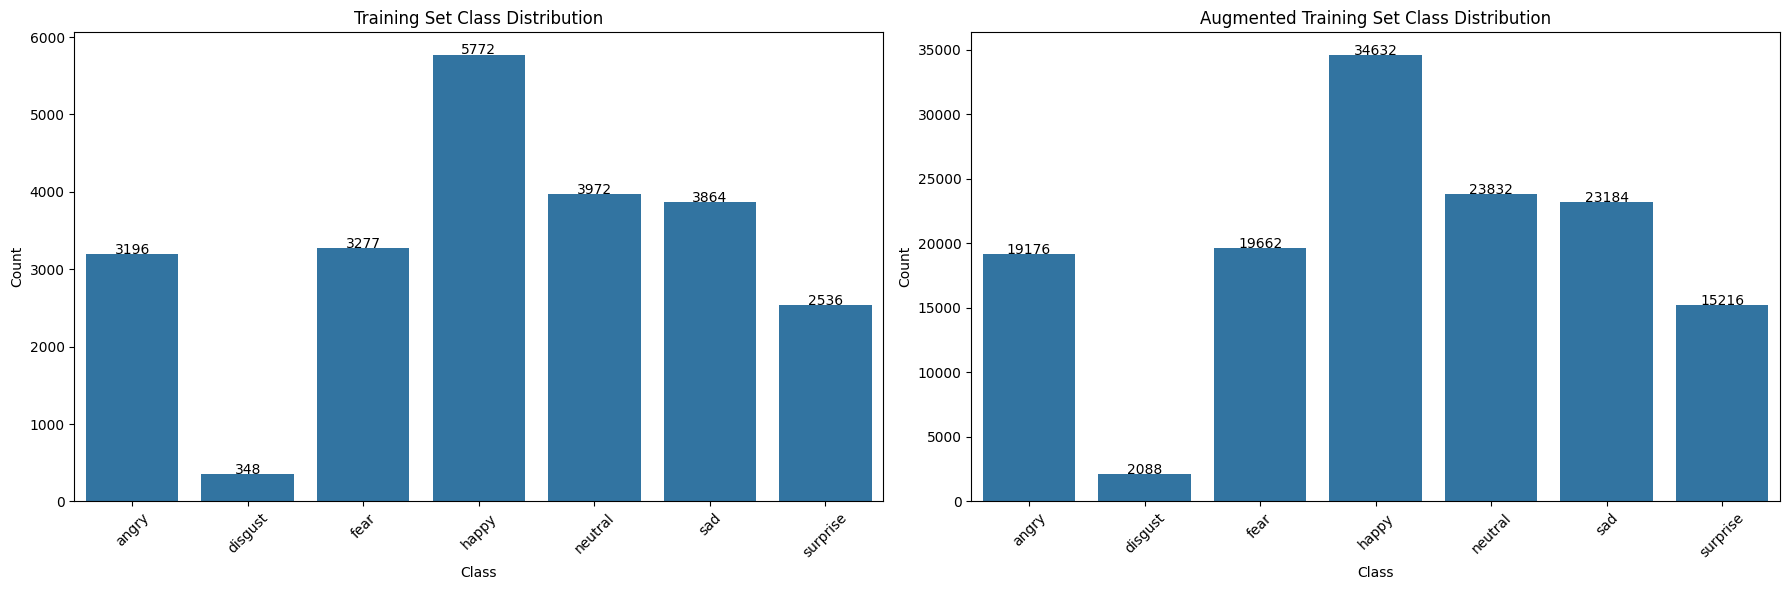

In [18]:
train_class_counts = count_images_in_directory(train_dir)

# Get test set class counts
augmented_train_class_counts = count_images_in_directory("data/augmented_merge")

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot train set class distribution
plot_with_counts(axes[0], train_class_counts, 'Training Set Class Distribution')

# Plot train_augmented set class distribution
plot_with_counts(axes[1], augmented_train_class_counts, 'Augmented Training Set Class Distribution')

plt.tight_layout()
plt.show()

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   rotation_range=10,
                                   width_shift_range= 0.1,
                                   height_shift_range= 0.1,
                                   shear_range= 0.2 )



training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)
val_set = val_datagen.flow_from_directory(val_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=False,
                                                color_mode='grayscale',
                                                class_mode='categorical')


Found 22965 images belonging to 7 classes.
Found 5744 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [16]:
def get_model(input_size, classes=7):
    # Khởi tạo mô hình Sequential
    model = tf.keras.models.Sequential()

    # Lớp Convolutional đầu tiên với 32 bộ lọc, kích thước kernel là 3x3, activation function là ReLU
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_size))
    # Lớp Convolutional thứ hai với 64 bộ lọc, kích thước kernel là 3x3, activation function là ReLU
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    # Lớp Batch Normalization giúp ổn định và tăng tốc quá trình học
    model.add(BatchNormalization())
    # Lớp MaxPooling giúp giảm kích thước không gian của đặc trưng, chọn giá trị lớn nhất từ mỗi vùng 2x2
    model.add(MaxPooling2D(2, 2))
    # Lớp Dropout với tỷ lệ dropout là 0.25 giúp giảm overfitting
    model.add(Dropout(0.25))
    # Lớp Convolutional thứ ba với 128 bộ lọc, kích thước kernel là 3x3, activation function là ReLU, sử dụng regularization L2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    # Lớp Convolutional thứ tư với 256 bộ lọc, kích thước kernel là 3x3, activation function là ReLU, sử dụng regularization L2
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    # Lớp Batch Normalization giúp ổn định và tăng tốc quá trình học
    model.add(BatchNormalization())
    # Lớp MaxPooling giúp giảm kích thước không gian của đặc trưng, chọn giá trị lớn nhất từ mỗi vùng 2x2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Lớp Dropout với tỷ lệ dropout là 0.25 giúp giảm overfitting
    model.add(Dropout(0.25))
    # Lớp Flatten chuyển đổi tensor thành vector để đưa vào lớp Fully Connected
    model.add(Flatten())
    # Lớp Fully Connected với 1024 neurons, activation function là ReLU
    model.add(Dense(1024, activation='relu'))
    # Lớp Dropout với tỷ lệ dropout là 0.5 giúp giảm overfitting
    model.add(Dropout(0.5))
    # Lớp đầu ra với số lượng neurons tương đương số lớp (classes), activation function là Softmax cho bài toán phân loại đa lớp
    model.add(Dense(classes, activation='softmax'))
    # Compile mô hình với optimizer là Adam, loss function là categorical crossentropy và metric là accuracy
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [17]:
fernet = get_model((48,48,1))
fernet.summary()

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    31,720,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,116,743 (122.52 MB)

 Trainable params: 32,116,103 (122.51 MB)

 Non-trainable params: 640 (2.50 KB)

In [18]:
from keras.models import load_model
fernet = load_model('model/final/model_17_5_file.h5')

In [19]:
fernet.compile(optimizer=Adam(learning_rate=0.0001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [1]:
with open('model/final/training.log', 'r') as f:
    lines = f.readlines()

# Khởi tạo các list để lưu trữ dữ liệu
epochs = []
train_accuracy = []
train_loss = []
lr = []
val_accuracy = []
val_loss = []

# Phân tích dữ liệu từ các dòng trong file
for line in lines[1:]:  # Bỏ qua dòng đầu tiên (header)
    parts = line.strip().split(',')
    epochs.append(int(parts[0]))
    train_accuracy.append(float(parts[1]))
    train_loss.append(float(parts[2]))
    lr.append(float(parts[3]))
    val_accuracy.append(float(parts[4]))
    val_loss.append(float(parts[5]))

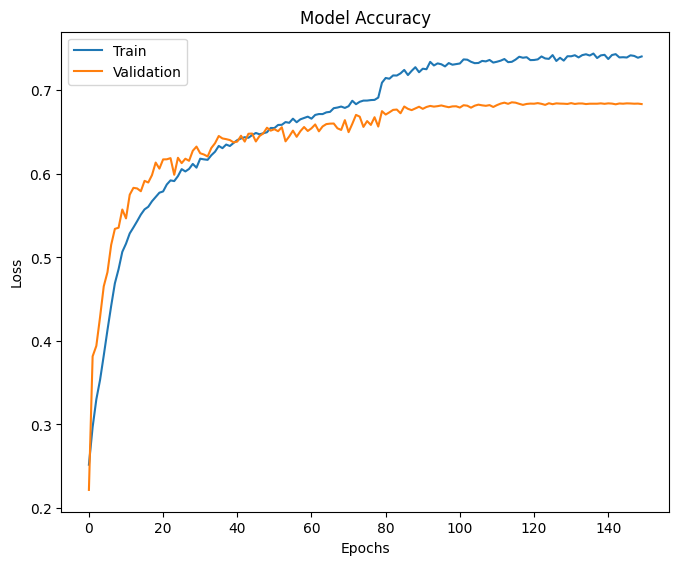

In [8]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

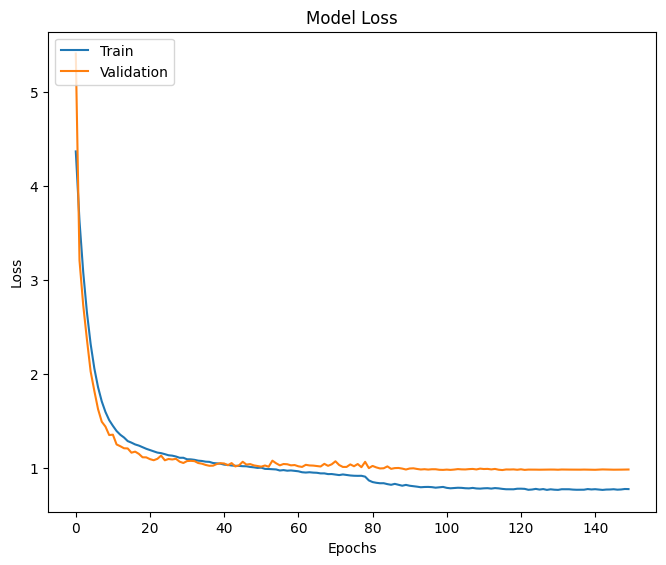

In [7]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

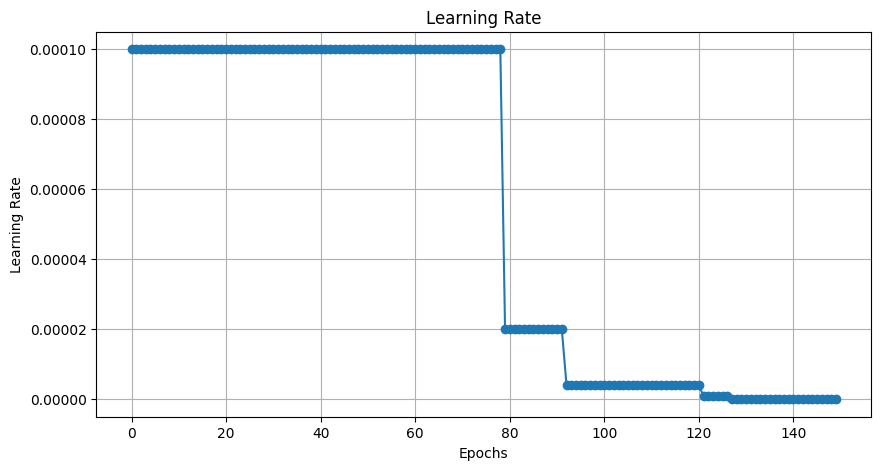

In [14]:
# Vẽ biểu đồ accuracy trên tập train và tập validation
plt.figure(figsize=(10, 5))
plt.plot(epochs, lr, marker='o')
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

In [20]:
test_loss, test_accuracy = fernet.evaluate(test_set)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - accuracy: 0.6437 - loss: 1.0887
Test loss: 0.9820839166641235, Test accuracy: 0.6837559342384338


In [21]:
from sklearn.metrics import confusion_matrix

# Dự đoán nhãn cho tập kiểm tra
predictions = fernet.predict(test_set)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_set.classes  # Nhãn thực tế từ generator

# Tạo ma trận nhầm lẫn
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Tính độ chính xác của từng lớp
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Vẽ biểu đồ
emotions = list(test_set.class_indices.keys())  # Lấy tên của các lớp từ generator

113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step


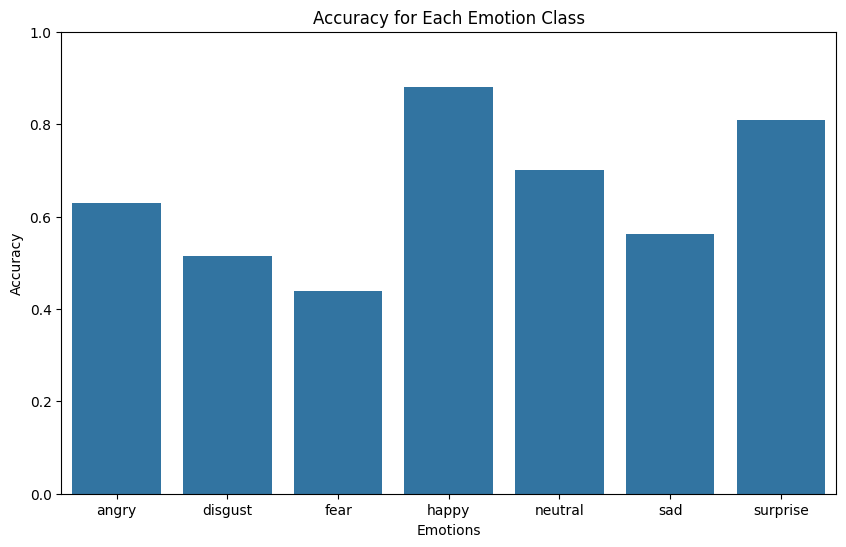

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x=emotions, y=class_accuracy)
plt.xlabel('Emotions')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Emotion Class')
plt.ylim(0, 1)
plt.show()


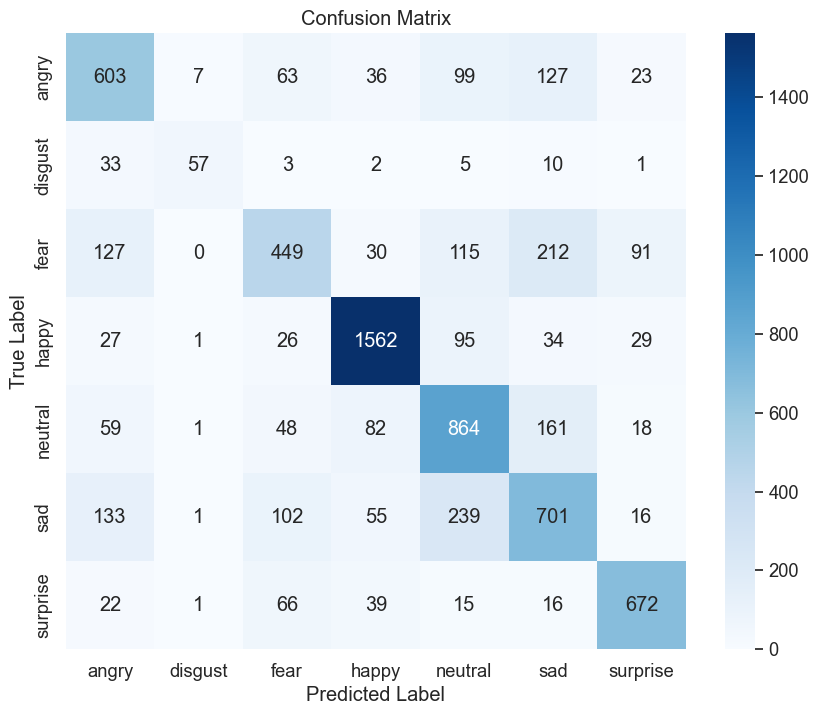

In [23]:
# Vẽ heat map
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Cài đặt kích thước font
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

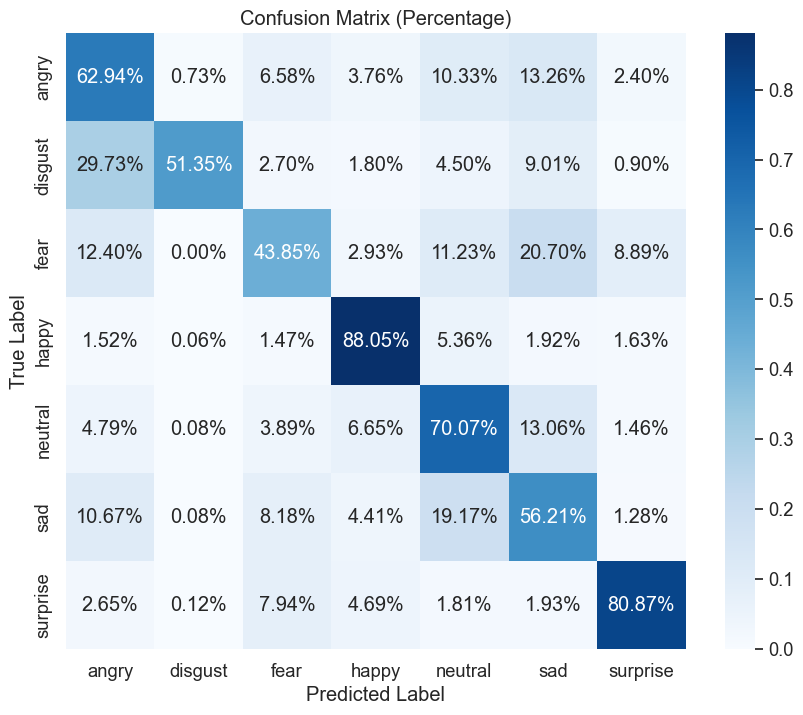

In [24]:
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Vẽ ma trận nhầm lẫn với các giá trị phần trăm
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Cài đặt kích thước font
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentage)')
plt.show()